# CountVectorizer / TfidfVectorizer를 활용한 WordCloud

In [1]:
import sys
import gc
import os
import re
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
# import chromedriver_autoinstaller

from matplotlib import font_manager, rc
# 차트에서 한글 출력을 위한 설정

import matplotlib.pyplot as plt
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='N# Stanza 형태소 분석기로 model 및 문장 벡터 생성anumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common. by import By

from bs4 import BeautifulSoup 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import konlpy
from konlpy.tag import Okt
from konlp.kma.klt2023 import klt2023
import nltk
import stanza
from gensim.models import Word2Vec, word2vec
from gensim.models import FastText

from wordcloud import WordCloud
from numpy import dot
from numpy.linalg import norm
import itertools

#### 데이터 전처리

In [3]:
# 중복 제거 및 데이터 불러오기
df = pd.read_csv('book_all.csv').drop_duplicates().reset_index(drop=True)

In [84]:
# 책소개에 이모티콘과 문장 부호가 많아, 더 깔끔한 데이터 확보를 위해 제거해줌.
for i in range(len(df)):
    df['책소개'][i] = re.sub("[^A-Za-z가-힣]",   # 바꿀패턴:영어, 한글이 아닌 모든것 제거
                      " ",                   # 바뀐내용:공백으로 바꿔라
                      df['책소개'][i] )

#### 불용어 + 각 카테고리명 추가

In [85]:
ko_Stopword = pd.read_csv('한국어 불용어.csv')['불용어'].to_list()

ko_Stopword.extend(['소설','시','에세이','인문','가정','육아','요리','건강','취미',
                                 '실용','스포츠','경제','경영','자기계발','정치','사회','역사','문화',
                                 '종교','예술','대중문화','기술','공학','외국어','과학','여행','컴퓨터',
                                 'IT','잡지','청소년'])

#### 형태소 분석기 정의

In [29]:
stanza.download('ko')
nlp = stanza.Pipeline('ko')

2023-04-15 17:52:16 INFO: Downloading default packages for language: ko (Korean) ...
2023-04-15 17:52:16 INFO: File exists: C:\Users\rudtj\stanza_resources\ko\default.zip
2023-04-15 17:52:18 INFO: Finished downloading models and saved to C:\Users\rudtj\stanza_resources.
2023-04-15 17:52:18 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-04-15 17:52:18 INFO: Loading these models for language: ko (Korean):
| Processor | Package |
-----------------------
| tokenize  | kaist   |
| pos       | kaist   |
| lemma     | kaist   |
| depparse  | kaist   |

2023-04-15 17:52:18 INFO: Using device: cuda
2023-04-15 17:52:18 INFO: Loading: tokenize
2023-04-15 17:52:19 INFO: Loading: pos
2023-04-15 17:52:19 INFO: Loading: lemma
2023-04-15 17:52:20 INFO: Loading: depparse
2023-04-15 17:52:20 INFO: Done loading processors!


In [107]:
def extract_nouns_stanza(text):
    doc = nlp(text)
    for sentence in doc.sentences:
        for word in sentence.words:
            lemma = word.lemma.split('+')
            xpos = word.xpos.split('+')
            for lem, pos in zip(lemma, xpos):
                if pos.startswith('n'):
                    yield lem

#### WordCloud 함수 정의

In [86]:
def wc_wc(cate, vectorizer='CV'):
    if vectorizer=='CV':
        vector = CountVectorizer(tokenizer = extract_nouns_stanza, max_features = 30 , stop_words=ko_Stopword)
    else:
        vector = TfidfVectorizer(tokenizer = extract_nouns_stanza, max_features = 30 , stop_words=ko_Stopword)
        
    tdm = vector.fit_transform(df.loc[df['카테고리']==cate, '책소개'])

    word_count = pd.DataFrame({
        '단어': vector.get_feature_names(),
        '빈도': tdm.sum(axis=0).flat
    })
    word_count.sort_values('빈도', ascending=False).head(10)
    
    word_count.set_index('단어')['빈도']
    count_dic = word_count.set_index('단어')['빈도'].to_dict()

    wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', 
                   background_color='white', max_words=30,
                   width=400, height=300, random_state = 0)

    cloud_society = wc.generate_from_frequencies(count_dic)
    
    display(word_count.sort_values('빈도', ascending=False).head(10))
    return cloud_society.to_image()

## 1. 소설

,단어,빈도
14,세계,189
9,사람,181
10,사랑,173
6,문학,131
12,삶,119
22,인간,115
19,시작,106
3,마음,78
23,인물,78
4,만,76


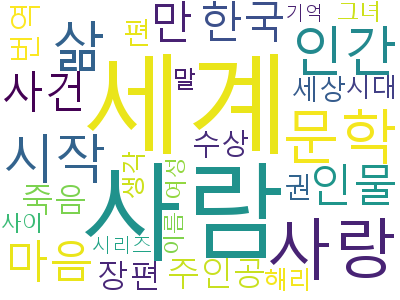

In [87]:
wc_wc("소설")

,단어,빈도
14,세계,31.150243
9,사람,28.528637
10,사랑,27.782989
6,문학,25.822703
22,인간,25.690537
19,시작,24.300071
12,삶,21.938113
3,마음,17.127662
4,만,17.018424
23,인물,16.734205


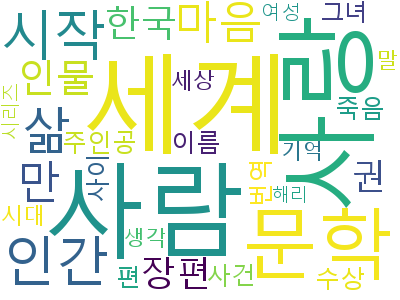

In [108]:
wc_wc("소설", 'tfidf')

## 2. 시/에세이

,단어,빈도
12,삶,311
10,사람,310
11,사랑,296
5,마음,210
17,시인,149
2,글,139
23,인생,131
14,세계,131
29,행복,121
13,생각,113


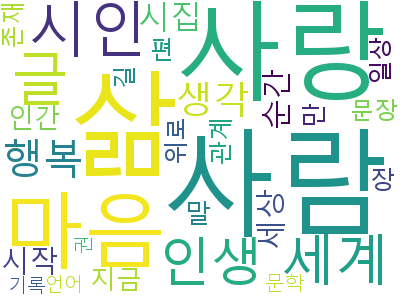

In [88]:
wc_wc("시/에세이")

,단어,빈도
10,사람,38.722527
12,삶,37.193885
11,사랑,32.929745
5,마음,29.423362
23,인생,23.702251
2,글,22.822609
14,세계,22.339972
17,시인,21.716619
19,시집,18.352463
13,생각,17.518013


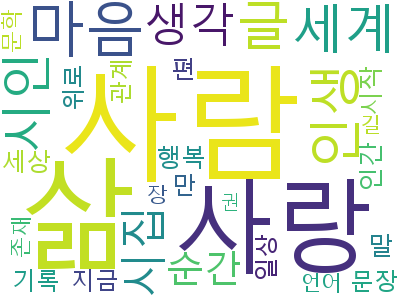

In [109]:
wc_wc("시/에세이", 'tfidf')

## 3. 인문

,단어,빈도
17,삶,295
15,사람,257
25,인간,167
18,생각,152
12,문제,148
27,인생,137
8,마음,130
19,세계,126
29,철학,103
10,말,101


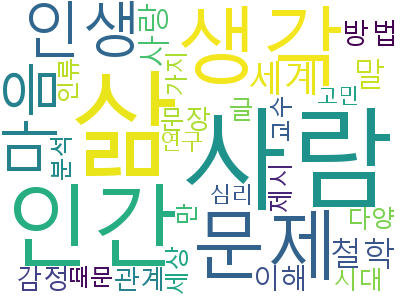

In [89]:
wc_wc("인문")

,단어,빈도
17,삶,34.222195
15,사람,31.268025
12,문제,28.107507
25,인간,27.273484
19,세계,20.927625
18,생각,20.923864
27,인생,20.715026
8,마음,18.713776
14,분석,18.167335
29,철학,17.623850


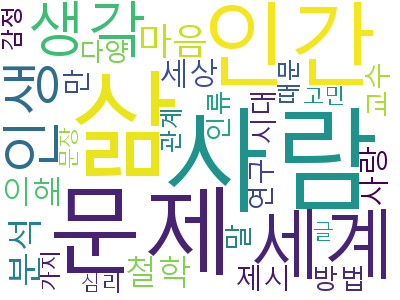

In [110]:
wc_wc("인문",'tfidf')

## 4. 가정/육아

,단어,빈도
15,부모,643
22,엄마,323
6,교육,258
3,공부,226
14,방법,177
23,영어,162
25,자녀,159
10,마음,155
13,발달,143
11,말,141


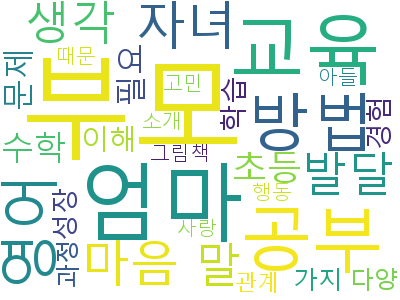

In [90]:
wc_wc("가정/육아")

,단어,빈도
15,부모,56.415003
22,엄마,35.667433
6,교육,29.208319
3,공부,23.908450
10,마음,22.586500
14,방법,21.661126
13,발달,21.324668
25,자녀,18.893154
17,생각,18.415251
26,초등,17.718180


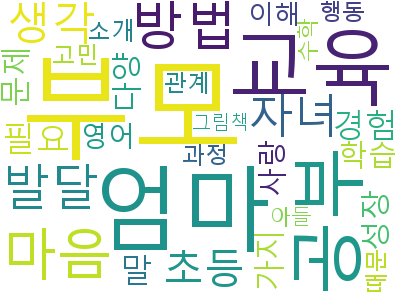

In [111]:
wc_wc("가정/육아",'tfidf')

## 5. 요리

,단어,빈도
7,레시피,396
23,재료,198
8,맛,179
27,커피,150
16,소개,147
5,다양,141
9,메뉴,141
0,가지,121
21,음식,121
19,와인,116


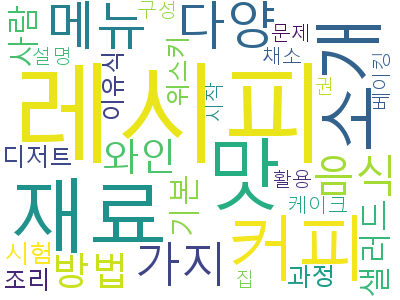

In [91]:
wc_wc("요리")

,단어,빈도
7,레시피,43.269865
23,재료,24.852608
8,맛,21.724410
16,소개,19.886770
5,다양,19.554723
0,가지,18.514118
9,메뉴,18.493064
21,음식,18.227247
10,문제,18.145926
18,시험,17.592208


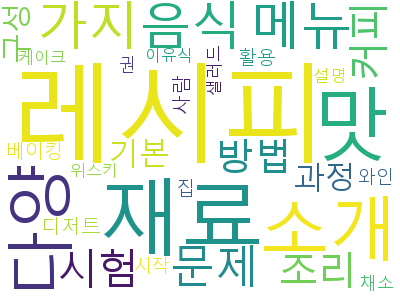

In [112]:
wc_wc("요리",'tfidf')

## 6. 건강

,단어,빈도
17,운동,309
6,몸,272
15,암,245
8,사람,203
7,방법,153
28,환자,144
24,치료,136
26,통증,119
23,질병,113
4,다이어트,111


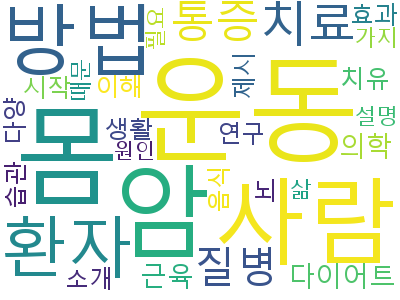

In [92]:
wc_wc("건강")

,단어,빈도
6,몸,30.518645
17,운동,27.870909
8,사람,24.827284
15,암,22.179520
7,방법,19.904026
24,치료,19.671372
23,질병,18.811001
28,환자,18.718264
20,의학,18.510472
4,다이어트,17.357688


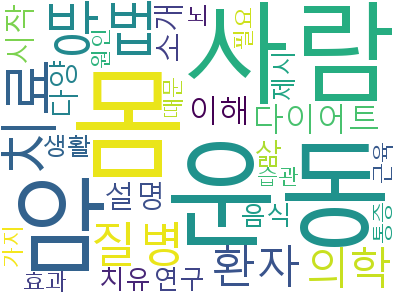

In [113]:
wc_wc("건강",'tfidf')

## 7. 취미/실용/스포츠

,단어,빈도
12,문제,124
20,수록,101
13,방법,97
9,다양,90
2,골프,88
10,도안,86
16,선수,83
19,소개,82
24,식물,77
28,축구,77


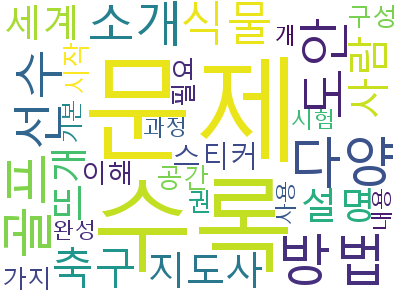

In [93]:
wc_wc("취미/실용/스포츠")

,단어,빈도
12,문제,25.272852
20,수록,21.183776
13,방법,19.223296
18,세계,18.310288
8,내용,17.905477
5,구성,15.690634
19,소개,15.578668
9,다양,15.576738
27,지도사,15.486174
14,사람,14.355907


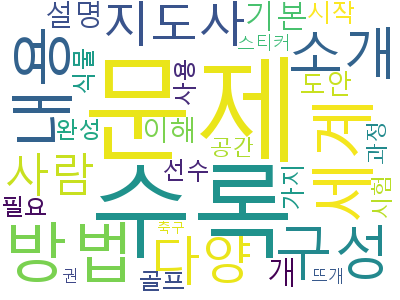

In [114]:
wc_wc("취미/실용/스포츠",'tfidf')

## 8. 경제/경영

,단어,빈도
26,투자,547
20,시장,202
24,주식,201
12,사람,181
27,투자자,168
9,부동산,164
2,기업,161
4,돈,153
11,분석,132
16,세계,132


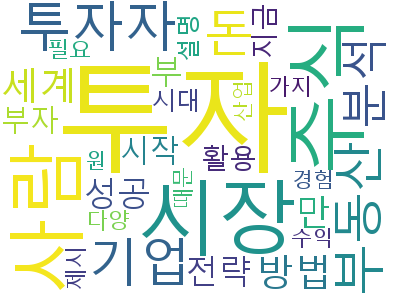

In [94]:
wc_wc("경제/경영")

,단어,빈도
26,투자,45.901907
2,기업,25.651329
12,사람,22.853998
20,시장,22.211842
16,세계,21.792353
24,주식,21.074235
4,돈,19.631541
9,부동산,18.535114
6,만,17.845178
11,분석,17.826103


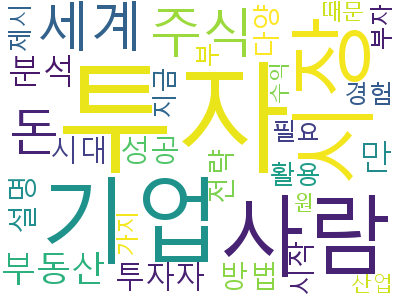

In [115]:
wc_wc("경제/경영",'tfidf')

## 9. 자기계발

,단어,빈도
15,사람,446
18,성공,279
16,삶,260
24,인생,239
17,생각,184
11,방법,158
19,세계,134
8,만,126
13,부,125
9,말,122


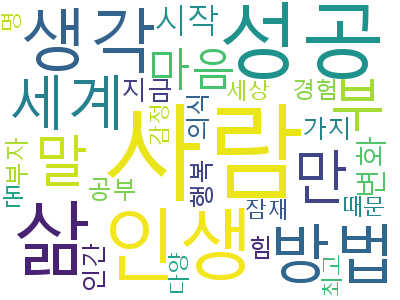

In [95]:
wc_wc("자기계발")

,단어,빈도
15,사람,41.925439
18,성공,35.781258
16,삶,32.902587
24,인생,29.358504
17,생각,25.519494
11,방법,22.272637
8,만,21.163237
19,세계,19.847351
21,시작,18.598703
7,마음,18.053164


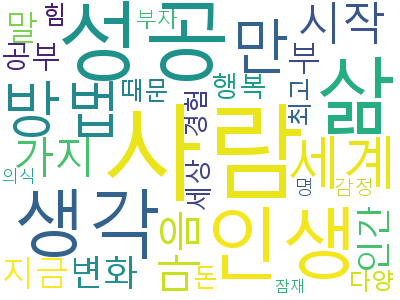

In [116]:
wc_wc("자기계발",'tfidf')

## 10. 정치/사회

,단어,빈도
19,세계,199
9,문제,151
14,사람,142
20,시대,112
28,한국,100
10,미국,95
26,판례,89
21,이해,86
3,국가,85
13,사건,83


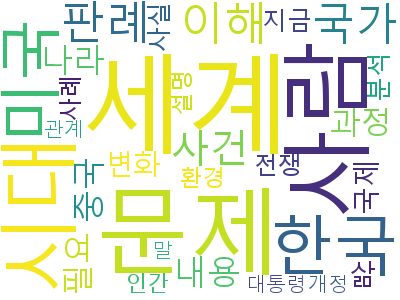

In [96]:
wc_wc("정치/사회")

,단어,빈도
19,세계,28.129681
14,사람,24.518933
9,문제,22.669074
6,내용,21.463584
28,한국,18.534991
20,시대,18.157018
1,과정,15.672213
21,이해,15.582416
17,삶,15.377243
3,국가,15.030292


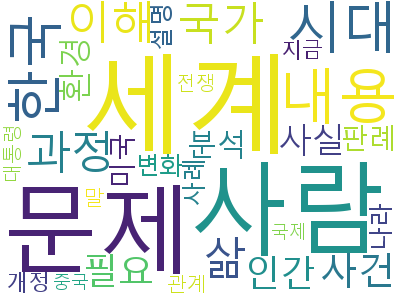

In [117]:
wc_wc("정치/사회",'tfidf')

## 11. 역사/문화

,단어,빈도
23,일본,203
12,세계,187
15,시대,163
24,전쟁,154
10,사람,133
28,한국,131
19,이해,126
25,조선,123
13,세계사,121
2,권,116


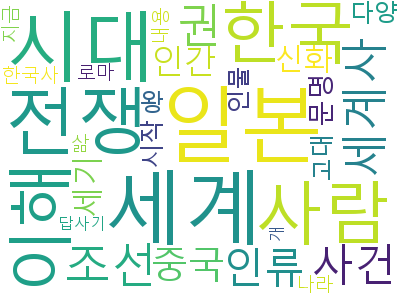

In [97]:
wc_wc("역사/문화")

,단어,빈도
12,세계,24.880020
23,일본,23.611972
15,시대,23.282419
10,사람,22.287721
25,조선,21.866111
24,전쟁,20.513429
28,한국,19.154187
13,세계사,18.621201
2,권,17.403209
21,인류,16.844779


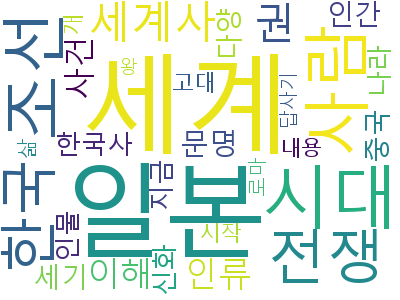

In [118]:
wc_wc("역사/문화",'tfidf')

## 12. 종교

,단어,빈도
28,하나님,274
18,성경,233
12,사람,171
14,삶,162
24,예수,141
3,기도,115
22,신앙,102
0,교회,94
7,말씀,79
26,이해,72


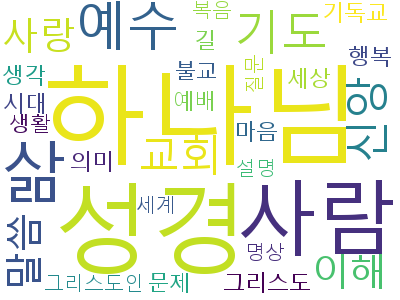

In [98]:
wc_wc("종교")

,단어,빈도
28,하나님,38.709049
18,성경,32.630524
14,삶,24.454285
12,사람,24.023002
24,예수,22.468604
13,사랑,16.989325
3,기도,16.452835
26,이해,15.905948
22,신앙,15.464417
0,교회,14.303938


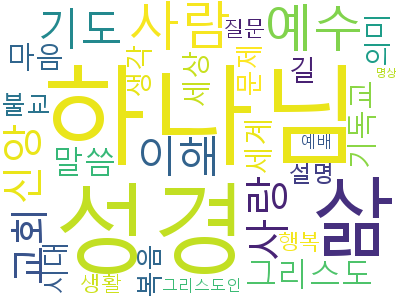

In [119]:
wc_wc("종교",'tfidf')

## 13. 예술/대중문화

,단어,빈도
23,음악,189
3,그림,139
9,미술,100
24,이론,86
1,구성,83
12,사람,83
0,교재,78
18,수록,76
27,피아노,73
16,설명,72


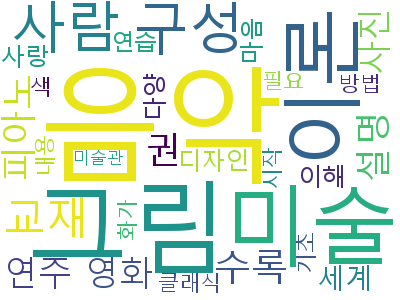

In [99]:
wc_wc("예술/대중문화")

,단어,빈도
23,음악,23.988392
3,그림,22.009547
0,교재,19.398046
9,미술,18.231777
18,수록,18.145717
27,피아노,17.622722
24,이론,16.896663
21,연주,16.282921
17,세계,16.003597
12,사람,15.833286


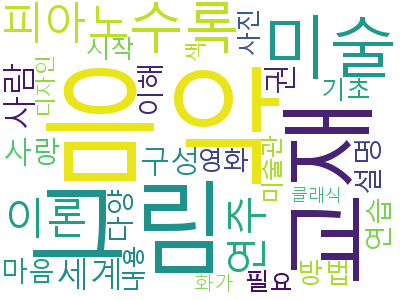

In [120]:
wc_wc("예술/대중문화",'tfidf')

## 14. 기술/공학

,단어,빈도
9,문제,614
24,출제,319
13,시험,280
16,이론,225
11,수록,209
26,학습,203
7,내용,186
27,합격,179
29,핵심,164
4,구성,138


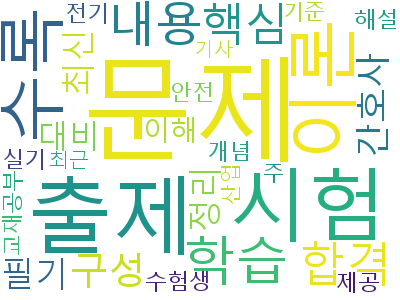

In [100]:
wc_wc("기술/공학")

,단어,빈도
9,문제,54.300978
24,출제,33.040700
13,시험,32.078550
11,수록,30.716607
7,내용,28.886202
26,학습,27.656798
16,이론,26.967246
29,핵심,24.005912
27,합격,21.921319
0,간호사,20.949422


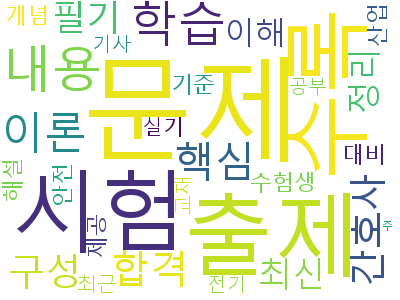

In [124]:
wc_wc("기술/공학",'tfidf')

## 15. 외국어

,단어,빈도
10,문제,417
26,학습,355
18,영어,336
20,제공,287
15,실전,274
14,시험,249
24,토익,236
5,단어,172
8,문법,167
22,최신,164


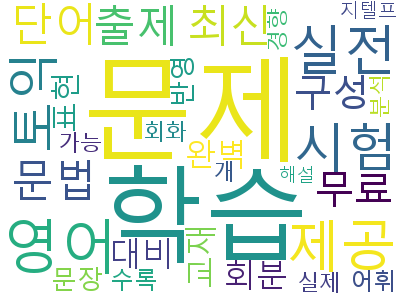

In [101]:
wc_wc("외국어")

,단어,빈도
10,문제,34.910991
18,영어,34.621074
26,학습,32.599018
24,토익,29.973754
20,제공,25.919551
15,실전,25.567454
14,시험,24.116494
5,단어,20.982578
25,표현,18.979917
8,문법,18.491131


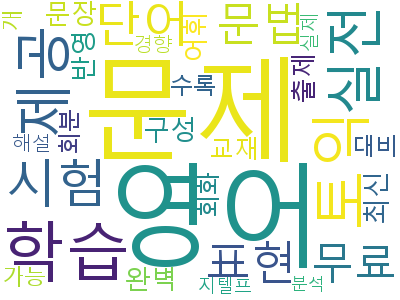

In [121]:
wc_wc("외국어",'tfidf')

## 16. 과학

,단어,빈도
17,수학,268
25,인간,175
24,이해,168
14,세계,167
21,우주,139
9,사람,125
4,뇌,121
13,설명,121
29,화학,112
15,세상,110


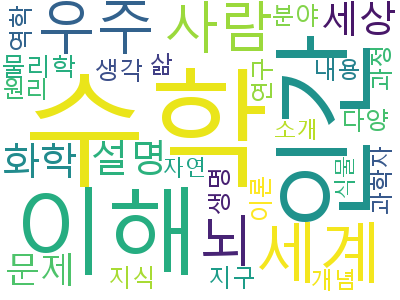

In [102]:
wc_wc("과학")

,단어,빈도
17,수학,25.686213
25,인간,22.725979
14,세계,22.441391
24,이해,19.677151
13,설명,19.346437
21,우주,19.331515
3,내용,17.854298
7,물리학,17.743070
4,뇌,17.234708
9,사람,16.365707


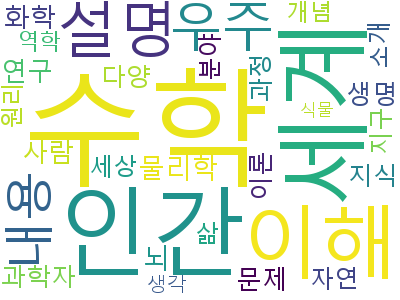

In [122]:
wc_wc("과학",'tfidf')

## 17. 여행

,단어,빈도
17,정보,340
15,여행지,221
0,가이드북,174
19,지도,170
12,소개,162
7,도시,162
14,여행자,150
21,최신,138
3,곳,135
6,다양,106


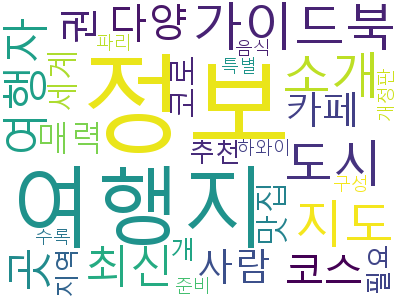

In [103]:
wc_wc("여행")

,단어,빈도
17,정보,40.579118
15,여행지,32.184984
7,도시,29.141291
0,가이드북,27.857700
12,소개,26.702304
3,곳,25.933341
14,여행자,23.642811
10,사람,22.660172
19,지도,20.637119
21,최신,20.432383


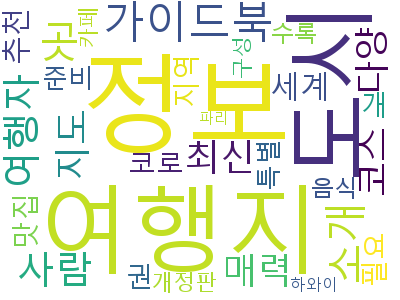

In [123]:
wc_wc("여행",'tfidf')

## 18. 컴퓨터/IT

,단어,빈도
8,문제,334
26,학습,199
5,내용,166
13,시험,156
29,활용,132
3,구성,130
12,설명,128
7,데이터,125
18,이해,123
9,방법,122


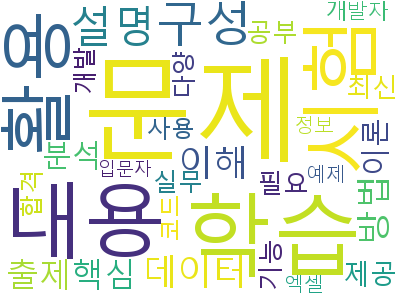

In [104]:
wc_wc("컴퓨터/IT")

,단어,빈도
8,문제,37.069581
26,학습,27.125884
9,방법,25.356837
5,내용,24.297716
12,설명,24.171447
18,이해,22.679276
29,활용,22.223830
13,시험,19.869328
7,데이터,19.343327
4,기능,18.874598


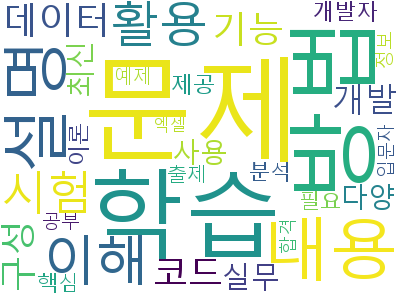

In [125]:
wc_wc("컴퓨터/IT",'tfidf')

## 19. 잡지

,단어,빈도
25,큐티,70
6,매거진,67
14,성경,65
5,말씀,54
8,묵상,50
16,소개,49
20,정보,49
12,브랜드,46
3,다양,39
7,매일,37


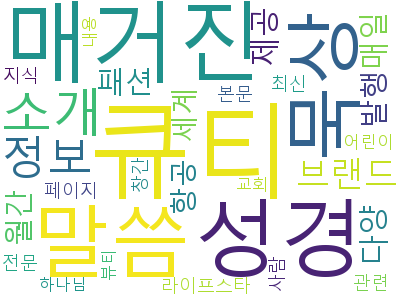

In [105]:
wc_wc("잡지")

,단어,빈도
6,매거진,19.774437
20,정보,15.272121
9,발행,15.157767
18,월간,14.873631
16,소개,14.848360
3,다양,12.391636
4,라이프스타,12.294244
26,패션,11.690622
19,전문,11.440447
13,사람,10.119967


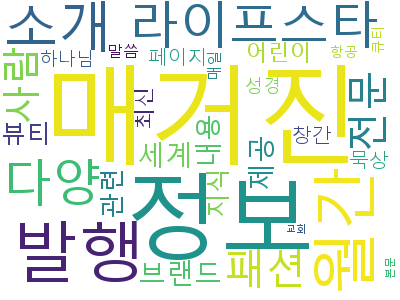

In [126]:
wc_wc("잡지",'tfidf')

## 20. 청소년

,단어,빈도
13,사람,152
19,수학,134
0,공부,130
17,세계,117
8,마음,112
29,학생,108
10,문제,107
15,생각,106
23,이해,100
26,친구,89


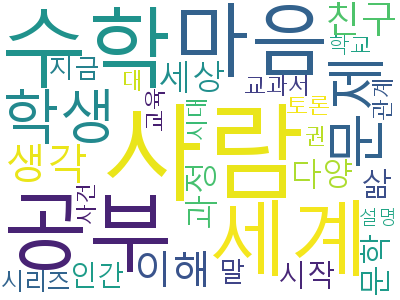

In [106]:
wc_wc("청소년")

,단어,빈도
13,사람,28.194605
17,세계,24.736421
8,마음,20.478002
14,삶,19.158782
15,생각,18.691611
24,인간,18.302117
26,친구,18.036342
18,세상,18.008088
23,이해,17.157375
22,시작,16.513796


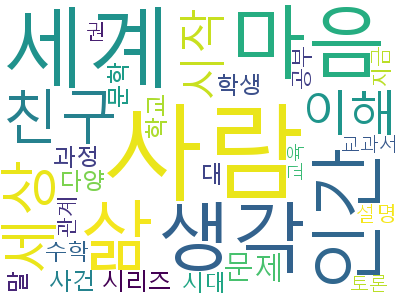

In [127]:
wc_wc("청소년",'tfidf')